In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.13.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## read the (cleaned) unlabel data
unlabel_data = pd.read_table("/content/drive/MyDrive/Colab Notebooks/cleaned_data.tsv", delimiter='\t')
# read the labeled data for identifying token
BI_label_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/partly_cleaned_train_data.tsv", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)

In [ ]:
#BI_label_data.head(20)
BI_label_data.tail(1)['Title'] == unlabel_data.iloc[4999]['Title']

55182    True
Name: Title, dtype: bool

In [ ]:
print(unlabel_data.head(20))

    Record Number                                              Title
0               1  Supreme Nike SB Dunk High By any Means Red US1...
1               2  New Balance 530 Männer und Frauen Laufschuhe m...
2               3                     ♥ MICHAEL KORS Sneaker Gr 39 ♥
3               4             New Balance ML 574 EGO Turnschuhe grün
4               5  Nike air jordan 9 og , space jam , hare , bugs...
5               6  NEU SKECHERS Damen Sneakers Turnschuhe Memory ...
6               7                        New Balance 550 White Green
7               8  CAT CATERPILLAR Arise Sneaker Freizeitschuhe T...
8               9  Adidas NMD R1 STLT PK Primeknit Sneaker Turnsc...
9              10  Damen Sneaker Mesh Sportschuhe Laufschuhe Slip...
10             11          Art 505 Schuhe Sneaker Sportschuhe Herren
11             12  C2886 sneaker uomo LANVIN VEGO scarpa nero mul...
12             13  New Balance 574 Herren-Sneaker Low Leder Retro...
13             14  Ecco ST. 1 Lite

In [ ]:
## create a dictionary of words and tags
long_string = " ".join(unlabel_data['Title'])
ger_dict = list(set(long_string.split()))
ger_dict.append('"')
ger_dict.append('\\"')
ger_dict.append("ENDPAD")
BI_dict = {0: "B", 1: "I"}

In [ ]:
ger_dict[0:20]

['8cd29f8',
 'falche',
 'Zinfandel-White',
 'luNar',
 '4f341e',
 '278011',
 'DM9095',
 'Mika',
 'W-Damenschuh',
 '1-1-23705-24-139',
 'gray-lime',
 '4fe1ecb',
 '6ff10c8',
 'AR6632-005',
 '9847bdf',
 '#ksyxypf',
 '43050',
 'high-tech',
 'T672n',
 '197c6']

In [ ]:
#tag_dict[0:20]

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.m_sent = 1
        self.data = data
        # splitting the cols of a sentence into token and tag
        agg_func = lambda s: [(w,t) for w,t in zip(s['Token'].values.tolist(),
                                                  s['C'].values.tolist())]
        self.grouped = self.data.groupby('Record.Number').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(BI_label_data)
sentences = getter.sentences
sentences[24]

[('Adidas', 'B'),
 ('Ultra', 'B'),
 ('Boost', 'I'),
 ('20', 'B'),
 ('Herren', 'B'),
 ('Sneaker', 'B'),
 ('Laufschuhe', 'B'),
 ('Turnschuhe', 'I'),
 ('schwarz', 'B'),
 ('FV8329', 'B'),
 ('NEU', 'B')]

In [ ]:
ger2idx = {w: i+1 for i, w in enumerate(ger_dict)}
BI2idx = {"B":0, "I": 1}

In [ ]:
#tag2idx

In [ ]:
## plot the length of each titles, commented out for debugging efficiency

# plt.hist(unlabel_data["Title"].str.len(), bins=20)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 98

X = [[ger2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value= len(ger_dict)-1)

y = [[BI2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=BI2idx["B"])
y = [to_categorical(i, num_classes=2) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
## creating a bi-directional RNN
input_word = Input(shape=(max_len, ))
BImodel = Embedding(input_dim=len(ger_dict), output_dim=max_len, input_length=max_len)(input_word)
BImodel = SpatialDropout1D(.1)(BImodel)
BImodel = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=.1))(BImodel)
out = TimeDistributed(Dense(2, activation = 'softmax'))(BImodel)
BImodel = Model(input_word, out)
BImodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding (Embedding)       (None, 98, 98)            185027528 
                                                                 
 spatial_dropout1d (Spatial  (None, 98, 98)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 98, 512)           727040    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 98, 2)             1026      
 ributed)                                                        
                                                             

In [ ]:
BImodel.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

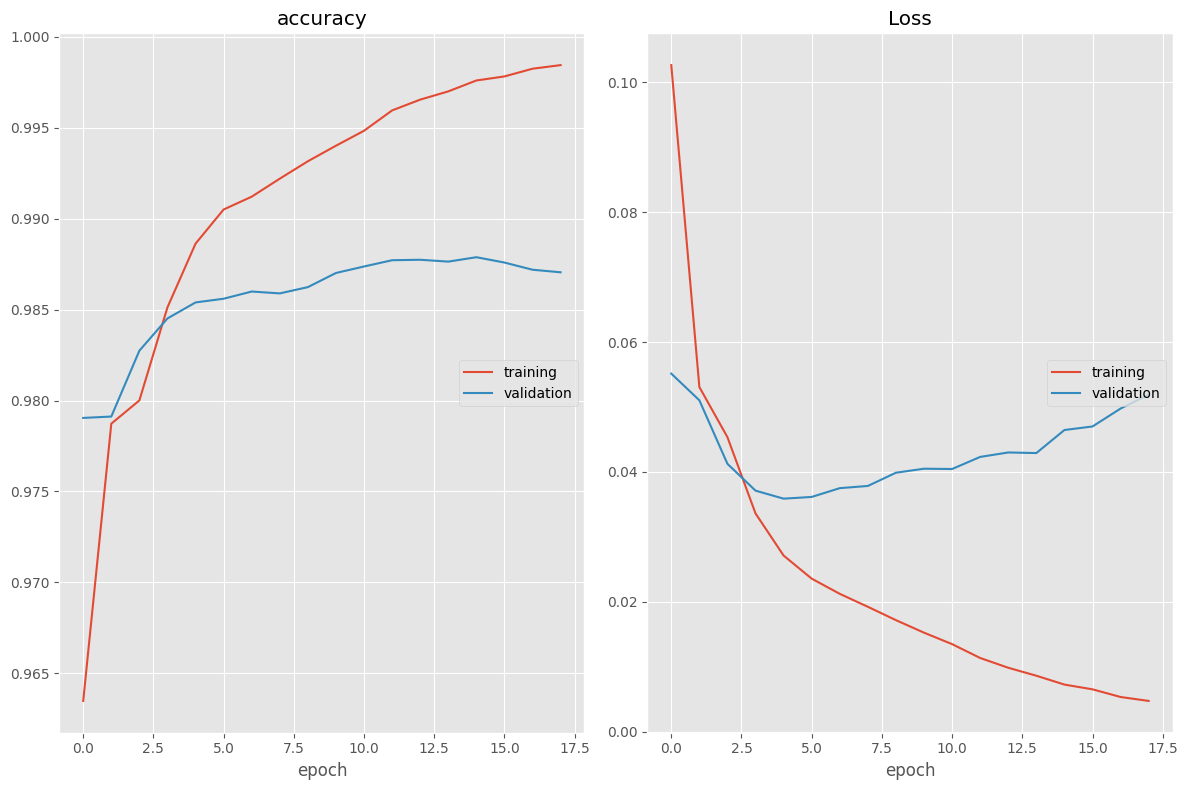

accuracy
	training         	 (min:    0.963, max:    0.998, cur:    0.998)
	validation       	 (min:    0.979, max:    0.988, cur:    0.987)
Loss
	training         	 (min:    0.005, max:    0.103, cur:    0.005)
	validation       	 (min:    0.036, max:    0.055, cur:    0.052)
50/50 [==============================] - 15s 310ms/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.0519 - val_accuracy: 0.9871


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = BImodel.fit(
    x_train, np.array(y_train),
    validation_split=.2,
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
BImodel.evaluate(x_test, np.array(y_test))

32/32 [==============================] - 2s 59ms/step - loss: 0.0518 - accuracy: 0.9872


[0.05175194516777992, 0.9872245192527771]

In [ ]:
predict = []
for i in range(5000, len(unlabel_data['Title'])):
    word_indices = []
    for word in unlabel_data['Title'][i].split():
        word_indices.append(ger2idx[word])
    predict.append(word_indices)

predict = pad_sequences(maxlen=max_len, sequences=predict, padding='post', value= len(ger_dict)-1)


In [ ]:
# TODO: hard input tokens so that the first model does not overfit
tokens_list = []
for i in range(5000, len(unlabel_data['Title']), 10):
    for j in range(10):
      p = BImodel.predict(np.array([predict[i+j]]))
      p = np.argmax(p, axis=-1)
      list_length = len(unlabel_data['Title'][i+j].split())
      token = ""
      i_tokens = []
      for tok, pred in zip(predict[i+j][0:list_length], p[0][0:list_length]):
        if BI_dict[pred] == "B":
          i_tokens.append(token)
          token = ger_dict[tok-1]
        elif (BI_dict[pred] == "I"):
          token = token + " " + ger_dict[tok-1]
      tokens_list.append(i_tokens[1::])
      with open("tokens.tsv", "a", newline="") as f:
        writer = csv.writer(f, delimiter='\t')
        for k in range(len(tokens_list)):
          for element in tokens_list[k]:
            writer.writerow([str(i+1)] + [element])

#tokens_list

In [29]:
!zip -r '/content/drive/MyDrive/Colab Notebooks/tokens.zip' '/content/drive/MyDrive/Colab Notebooks/tokens.tsv'

  adding: content/drive/MyDrive/Colab Notebooks/tokens.tsv (deflated 80%)


NameError: ignored

In [ ]:
#TODO: lắp token vào title, sau đó train model thứ 2 và classify trên cái tokens đấy như đã làm

## read the (cleaned) label data
label_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train_data.tsv", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)

# read the unlabel data (with token)
unlabel_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/unlabel_with_token.tsv", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)

#print("Unique tag in corpus: ", label_data['Tag'].nunique())

#ger_label_dict = list(set(label_data['Token']))
#train2idx = {w: i+1 for i, w in enumerate(ger_label_dict)}

In [ ]:
#create a dictionary of tokens and tags
token_dict = list(set(unlabel_data['Token']))
tag_dict = list(set(label_data['Tag']))

In [ ]:
class SentenceTokenGetter(object):
    def __init__(self, data):
        self.m_sent = 1
        self.data = data
        # splitting the cols of a sentence into token and tag
        agg_func = lambda s: [(w,t) for w,t in zip(s['Token'].values.tolist(),
                                                  s['Tag'].values.tolist())]
        self.grouped = self.data.groupby("Record Number").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceTokenGetter(label_data)
sentences = getter.sentences
sentences[0]

In [ ]:
tag2idx = {w: i for i, w in enumerate(tag_dict)}
token2idx = {w: i for i, w in enumerate(token_dict)}

In [ ]:
max_len = 104

X = [[token2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value= len(token_dict)-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["No Tag"])
y = [to_categorical(i, num_classes=len(tag_dict)) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
## creating a bi-directional RNN
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=len(token2idx), output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(.1)(model)
model = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=.1))(model)
out = TimeDistributed(Dense(len(tag_dict), activation = 'softmax'))(model)
model = Model(input_word, out)
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=.2,
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
predict = []
for i in range(44563, len(unlabel_data['Token'])):
  if unlabel_data['Record.Number'].iloc[i] != unlabel_data['Record.Number'].iloc[i-1]:
    predict.append(word_indices)
    word_indices = [unlabel_data['Token'].iloc[i]]
  else: word_indices.append(unlabel_data['Token'].iloc[i])
  predict.append(word_indices)

predict = pad_sequences(maxlen=max_len, sequences=predict, padding='post', value= len(ger_dict)-1)

In [ ]:
#TODO: finish predicting the tag for all tokens in the unlabel file and write
#the (ascending order, sorted by Tag) result to a tsv file

tokens_list = []
for i in range(44563, len(unlabel_data['Title'])):
  p = model.predict(np.array([predict[i]]))
  p = np.argmax(p, axis=-1)

  list_length = len(unlabel_data['Title'][i].split())
  token = ""
  i_tokens = []
  for tok, pred in zip(predict[i][0:list_length], p[0][0:list_length]):
    if BI_dict[pred] == "B":
      i_tokens.append(token)
      token = ger_dict[tok-1]
    elif (BI_dict[pred] == "I"):
      token = token + " " + ger_dict[tok-1]
  tokens_list.append(i_tokens[1::])